In [1]:
from LoopDataConverter import LoopConverter, InputData, SurveyName, Datatype, NtgsConfig
from osgeo import gdal, osr
import os 
from map2loop import Project#, logging
import map2loop
import tempfile
# logging.set_level('debug')

/home/rabii/Git_Repos/map2loop/map2loop/__init__.py:113: UserWarning: dependencies.txt not found. No dependencies checked for map2loop.
  warnings.warn(


In [2]:
def create_raster(output_path, bbox, epsg, pixel_size, value=100):
    minx, miny, maxx, maxy = bbox
    cols = int((maxx - minx) / pixel_size)
    rows = int((maxy - miny) / pixel_size)
    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)
    out_raster.SetGeoTransform([minx, pixel_size, 0, maxy, 0, -pixel_size])
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    out_raster.SetProjection(srs.ExportToWkt())
    out_band = out_raster.GetRasterBand(1)
    out_band.Fill(value)
    out_band.FlushCache()
    out_raster = None

In [3]:
import geopandas

def get_bounding_box(shapefile_path, zmax=3000, zmin=-3000):
    """
    Returns the bounding box of the given shapefile.
    
    Parameters:
        shapefile_path (str): Path to the shapefile.
    
    Returns:
        dict: Bounding box with minx, miny, maxx, maxy.
    """
    gdf = geopandas.read_file(shapefile_path)
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    bounding_box = {
        "minx": bounds[0],
        "miny": bounds[1],
        "maxx": bounds[2],
        "maxy": bounds[3],
        "base": zmin,
        "top": zmax,
    }
    return bounding_box

bounding_box = get_bounding_box("../test_data/NTGS_data/Henbury/bounding_box.shp")

# xmin, ymax = 194809, 7342124
# xmax, ymin = 269919, 7314400
# zmin, zmax = -3000, 3000
# bounding_box = {
#     "minx": xmin,
#     "miny": ymin,
#     "maxx": xmax,
#     "maxy": ymax,
#     "base": zmin,
#     "top": zmax,
# }
f_path = "/home/rabii/Git_Repos/LoopDataConverter/test_data/NTGS_data/Henbury"
create_raster(
    os.path.join(f_path, "DEM.tif"),
    (bounding_box['minx'], bounding_box['miny'], bounding_box['maxx'], bounding_box['maxy']),
    7854,
    1000,
)
bounding_box

{'minx': np.float64(194915.04765542696),
 'miny': np.float64(7314111.534384862),
 'maxx': np.float64(269996.050907918),
 'maxy': np.float64(7343389.948186358),
 'base': -3000,
 'top': 3000}

In [4]:
input_data = InputData(
    GEOLOGY="../test_data/NTGS_data/Henbury/NT_LithOutcrop_250k_shp.shp", 
    STRUCTURE="../test_data/NTGS_data/Henbury/NT_StructData_250k_shp.shp",
    FAULT="../test_data/NTGS_data/Henbury/NT_Fault_250k_shp.shp",
    FOLD="../test_data/NTGS_data/Henbury/NT_Fold_250k_shp.shp"
)

loop_converter = LoopConverter(survey_name=SurveyName.NTGS,
                               data=input_data)
loop_converter.convert()

In [5]:
loop_converter.data[Datatype.FAULT_ORIENTATION].loc[loop_converter.data[Datatype.FAULT_ORIENTATION].index == 31, 'Strike'] = 270
loop_converter.data[Datatype.FAULT_ORIENTATION].loc[loop_converter.data[Datatype.FAULT_ORIENTATION].index == 28, 'Strike'] = 235
loop_converter.data[Datatype.FAULT_ORIENTATION].loc[loop_converter.data[Datatype.FAULT_ORIENTATION].index == 30, 'Strike'] = 135

# rows_to_delete = list(range(18, 32))
# rows_to_delete.remove(20)
# rows_to_delete.remove(31)
# loop_converter.data[Datatype.FAULT_ORIENTATION].drop(rows_to_delete, inplace=True)



In [24]:
rows_to_delete

[18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [12]:
loop_converter.data[Datatype.FAULT_ORIENTATION]

,featureId,X,Y,Z,DipDir,Dip,geometry
12,205,221419.114435,7.334860e+06,0.0,225.0,45.0,POINT (221419.114 7334860.227)
13,248,235303.410765,7.327076e+06,0.0,0.0,75.0,POINT (235303.411 7327075.503)
14,329,221402.989713,7.334874e+06,0.0,180.0,45.0,POINT (221402.99 7334873.574)
15,420,198101.786289,7.317804e+06,0.0,45.0,45.0,POINT (198101.786 7317804.047)
16,494,235948.984184,7.329999e+06,0.0,180.0,75.0,POINT (235948.984 7329998.593)
17,551,241465.898731,7.331696e+06,0.0,180.0,75.0,POINT (241465.899 7331696.005)
18,554,223313.619069,7.334932e+06,0.0,180.0,75.0,POINT (223313.619 7334931.516)


In [5]:
path = tempfile.mkdtemp()
loop_converter.save(Datatype.GEOLOGY, os.path.join(path, "geology.shp"), file_extension="shp")
loop_converter.save(Datatype.STRUCTURE, os.path.join(path, "structures.shp"), file_extension="shp")
loop_converter.save(Datatype.FOLD, os.path.join(path, "folds.shp"), file_extension="shp")
loop_converter.save(Datatype.FAULT, os.path.join(path, "faults.shp"), file_extension="shp")
loop_converter.save(Datatype.FAULT_ORIENTATION, os.path.join(path, "fault_orientations.shp"), file_extension="shp")

In [6]:
import os
from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel
from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator
from map2loop.sorter import SorterUseHint, SorterUseNetworkX, SorterAgeBased, SorterAlpha, SorterObservationProjections
from map2loop.thickness_calculator import InterpolatedStructure, StructuralPoint, ThicknessCalculatorAlpha
import time
from datetime import datetime
# nowtime=datetime.now().isoformat(timespec='minutes')
# model_name=nowtime.replace(":","-").replace("T","-")
loop_project_filename = os.path.join("processed_data/HB_map2.loop3d")
project_path = tempfile.mkdtemp()
t0 = time.time()
structure_config = {
            "orientation_type": "strike",
            "dipdir_column": "DIPDIR",
            "dip_column": "DIP",
            "description_column": "",
            "bedding_text": "",
            "overturned_column": "",
            "overturned_text": "",
            "objectid_column": "OBJECTID",
            "interp_source_column": "",
        }
ntgs_config = NtgsConfig()
config = ntgs_config.config_map
config['structure'] = structure_config

# Initialise the project with the shapefiles, dtm, config file
# output locations and projection to work in
proj = Project(
    geology_filename = os.path.join(path, "geology.shp"),
    fault_filename = os.path.join(path, "faults.shp"),
    fault_orientation_filename = os.path.join(path, "fault_orientations.shp"),
    structure_filename = '../test_data/NTGS_data/Henbury/site_HenburyStructure.shp', #os.path.join(path, "structures.shp"),
    fold_filename= os.path.join(path, "folds.shp"),
    dtm_filename = "../test_data/NTGS_data/Henbury/DEM.tif",
    config_dictionary= config,
    clut_filename = '../test_data/NTGS_data/500kibg_colours.csv',
    clut_file_legacy = True,
    verbose_level = VerboseLevel.ALL,
    tmp_path = project_path,
    working_projection = "EPSG:28353",#"EPSG:4283",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename,
    overwrite_loopprojectfile = True
)

# Remove faults less than 5km
proj.set_minimum_fault_length(0.0)

# Set sampling distance for geology and fault maps to 200m
proj.set_sampler(Datatype.GEOLOGY, SamplerSpacing(50.0))
proj.set_sampler(Datatype.FAULT, SamplerSpacing(200.0))

# Set to only take every second orientation observation (0 or 1 means take all observations)
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(2))

# Set what text is expected for intrusions (contained within the description field)
# proj.map_data.config.geology_config["intrusive_text"] = "mafic intrusive"

# Set specific layers from the geology map to be ignored (commonly "cover" or "water")
proj.set_ignore_lithology_codes(["None", "No_formal_name", "Julie_Formation", "Stokes_Siltstone",])

proj.set_thickness_calculator(InterpolatedStructure())
# Specify which stratigraphic columns sorter to use, other options are
# (SorterAlpha, SorterAgeBased, SorterUseHint, SorterUseNetworkX, SorterMaximiseContacts, SorterObservationProjections)
proj.set_sorter(SorterObservationProjections())

# Or you can run map2loop and pre-specify the stratigraphic column
# column = [
#     # youngest
#     'No_formal_name',
#     'Chandler_Limestone',
#     'Arumbera_Sandstone',
#     'Pertatataka_Formation',
#     'Waldo_Pedlar_Formation',
#     'Aralka_Formation',
#     'Areyonga_Formation',
#     'Bitter_Springs_Formation'
#     # oldest
# ]

full_column = [
    # youngest
    'No_formal_name',
    "Brewer_Conglomerate",
    "Hermannsburg_Sandstone",
    "Parke_Siltstone",
    "Mereenie_Sandstone",
    "Carmichael_Sandstone",
    "Stokes_Siltstone",
    "Stairway_Sandstone",
    "Horn_Valley_Siltstone",
    "Pacoota_Sandstone",
    "Goyder_Formation",
    "Jay_Creek_Limestone",
    "Petermann_Sandstone",
    "Deception_Formation",
    "Illara_Sandstone",
    "Tempe_Formation",
    "Chandler_Formation",
    "Arumbera_Sandstone",
    "Namatjira_Formation",
    "Puna_Kura_Kura_Formation",
    "Julie_Formation",
    "Liddle_Formation",
    "Pertatataka_Formation",
    "Froud_Formation",
    "Gloaming_Formation",
    "Quandong_Conglomerate",
    "Breaden_Formation",
    "Pioneer_Sandstone",
    "Aralka_Formation",
    "Areyonga_Formation",
    "Wallara_Formation",
    "Johnnys_Creek_Formation",
    "Loves_Creek_Formation",
    "Gillen_Formation",
    
    # oldest
]

column = [
    # 'No_formal_name',
    'Hermannsburg_Sandstone',
    'Parke_Siltstone',
    'Mereenie_Sandstone',
    'Carmichael_Sandstone',
    'Stokes_Siltstone',
    'Stairway_Sandstone',
    'Horn_Valley_Siltstone',
    'Pacoota_Sandstone',
    'Goyder_Formation',
    'Petermann_Sandstone',
    'Deception_Formation',
    'Illara_Sandstone',
    'Tempe_Formation',
    'Chandler_Formation',
    'Arumbera_Sandstone',
    'Namatjira_Formation',
    'Julie_Formation',
    'Pertatataka_Formation',
    'Areyonga_Formation',
    'Wallara_Formation',
    'Johnnys_Creek_Formation',
    'Loves_Creek_Formation'
 ]

proj.run_all(user_defined_stratigraphic_column=column)
# Or you can get map2loop to run all column sorting algorithms it has and takes the one
# that has the longest total basal contact length
# proj.run_all(take_best=False)
# proj.run_all()

t1 = time.time()

/home/rabii/Git_Repos/m2l_pypi/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [7]:
proj.stratigraphic_column.stratigraphicUnits

,layerId,name,minAge,maxAge,group,supergroup,stratigraphic_Order,InterpolatedStructure_mean,InterpolatedStructure_median,InterpolatedStructure_stddev,code,colour
0,6,Hermannsburg_Sandstone,-9999.0,-9999.0,,None,0,-1.000000,-1.000000,-1.000000,NaN,#74fbf4
1,14,Parke_Siltstone,-9999.0,-9999.0,,None,1,10109.177729,4980.236526,7821.054591,NaN,#e7f2f3
2,11,Mereenie_Sandstone,-9999.0,-9999.0,,None,2,5597.382171,5595.411042,18.757256,SD__me_st,#F7E8FE
3,2,Carmichael_Sandstone,-9999.0,-9999.0,,None,3,-1.000000,-1.000000,-1.000000,NaN,#fb0fda
4,17,Stairway_Sandstone,-9999.0,-9999.0,,None,5,-1.000000,-1.000000,-1.000000,NaN,#7c2e17
5,7,Horn_Valley_Siltstone,-9999.0,-9999.0,,None,6,199.423948,215.833210,65.848605,NaN,#a2f290
6,13,Pacoota_Sandstone,-9999.0,-9999.0,,None,7,2369.020078,2072.827806,1482.080209,NaN,#d0d47c
7,5,Goyder_Formation,-9999.0,-9999.0,,None,8,10558.044844,10494.727829,6200.960491,NaN,#1932e2
8,16,Petermann_Sandstone,-9999.0,-9999.0,,None,9,271.962422,294.387395,52.004392,NaN,#5d7e60
9,4,Deception_Formation,-9999.0,-9999.0,,None,10,495.081250,582.041223,214.459496,NaN,#8e9aef


In [22]:
proj.thickness_calculator[0].location_tracking

,p1_x,p1_y,p1_z,p2_x,p2_y,p2_z,thickness,unit
0,195258.221861,7.323483e+06,0.0,219768.481712,7.338227e+06,0.0,"[14761.694488962836, 14486.46185159159, 14813....",Hermannsburg_Sandstone
1,195257.304315,7.323533e+06,0.0,219768.481712,7.338227e+06,0.0,"[14748.818069292922, 14800.575047250039, 14251...",Hermannsburg_Sandstone
2,195256.386769,7.323583e+06,0.0,219768.481712,7.338227e+06,0.0,"[14735.975584247035, 14787.68749498505, 14239....",Hermannsburg_Sandstone
3,195255.469222,7.323633e+06,0.0,219768.481712,7.338227e+06,0.0,"[14774.834085539378, 14226.914841126985, 14827...",Hermannsburg_Sandstone
4,195254.551676,7.323683e+06,0.0,219768.481712,7.338227e+06,0.0,"[14762.014908098608, 14814.729916642531, 14542...",Hermannsburg_Sandstone
...,...,...,...,...,...,...,...,...
4468,219799.499514,7.336458e+06,0.0,219580.108865,7.337437e+06,0.0,[],Wallara_Formation
4469,219819.368155,7.336412e+06,0.0,219580.109817,7.337437e+06,0.0,[],Wallara_Formation
4470,219839.236796,7.336366e+06,0.0,219580.109817,7.337437e+06,0.0,[],Wallara_Formation
4471,219859.105437,7.336320e+06,0.0,219580.109817,7.337437e+06,0.0,[],Wallara_Formation


In [7]:
proj.map_data.get_map_data(Datatype.FAULT_ORIENTATION)

,geometry,DIPDIR,DIP,ID,featureId
3,POINT (198101.786 7317804.047),45.0,45.0,0,420
1,POINT (235303.411 7327075.503),0.0,75.0,1,248
4,POINT (235948.984 7329998.593),180.0,75.0,2,494
5,POINT (241465.899 7331696.005),180.0,75.0,3,551
0,POINT (221419.114 7334860.227),225.0,45.0,4,205
2,POINT (221402.99 7334873.574),180.0,45.0,5,329
6,POINT (223313.619 7334931.516),225.0,75.0,6,554


In [7]:
# Create a set from column_2 for faster lookup
column_2_set = set(column_2)

# Reorder column_2 to match the order in column_1
reordered_column_2 = [formation for formation in column_1 if formation in column_2_set]
reordered_column_2

NameError: name 'column_2' is not defined

In [7]:
import LoopProjectFile as LPF
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor


LPFilename = loop_project_filename
projFile = LPF.ProjectFile(LPFilename)
processedData = LPFProcessor(projFile)
processedData.thicknesses["Hermannsburg_Sandstone"] = 5e4
processedData.thicknesses["Loves_Creek_Formation"] = 200
processedData.thicknesses["Namatjira_Formation"] = 1000
processedData.thicknesses["Pertatataka_Formation"] = 1000
processedData.thicknesses["Stairway_Sandstone"] = 1000
processedData.thicknesses["Carmichael_Sandstone"] = 1000
processedData.thicknesses["Parke_Siltstone"] = 3000
processedData.thicknesses["Illara_Sandstone"] = 3000
processedData.thicknesses["Wallara_Formation"] = 3000
processedData.thicknesses["Areyonga_Formation"] = 3000

ERROR: 2025-04-16 12:23:55,401: process_data.py:460 -- Thickness for Pertatataka_Formation is less than or equal to 0
 Update the thickness value for Pertatataka_Formation before continuing
ERROR: 2025-04-16 12:23:55,402: process_data.py:460 -- Thickness for Namatjira_Formation is less than or equal to 0
 Update the thickness value for Namatjira_Formation before continuing
ERROR: 2025-04-16 12:23:55,402: process_data.py:460 -- Thickness for Stairway_Sandstone is less than or equal to 0
 Update the thickness value for Stairway_Sandstone before continuing
ERROR: 2025-04-16 12:23:55,402: process_data.py:460 -- Thickness for Carmichael_Sandstone is less than or equal to 0
 Update the thickness value for Carmichael_Sandstone before continuing


In [29]:
import numpy
def strike_dip_vector(strike, dip) -> numpy.ndarray:
    """
    Calculates the strike-dip vector from the given strike and dip angles.

    Args:
        strike (Union[float, list, numpy.ndarray]): The strike angle(s) in degrees.
        dip (Union[float, list, numpy.ndarray]): The dip angle(s) in degrees.

    Returns:
        numpy.ndarray: The calculated strike-dip vector(s). Each row corresponds to a vector,
        and the columns correspond to the x, y, and z components of the vector.
    """

    # If strike or dip is a single value, wrap them into a list
    if not isinstance(strike, (list, numpy.ndarray)):
        strike = [strike]
    if not isinstance(dip, (list, numpy.ndarray)):
        dip = [dip]

    # Convert to numpy arrays
    strike = numpy.array(strike)
    dip = numpy.array(dip)

    # Initialize a zero matrix with shape (n, 3)
    vec = numpy.zeros((len(strike), 3))

    # Convert strike and dip from degrees to radians
    s_r = numpy.deg2rad(strike)
    d_r = numpy.deg2rad(dip)

    # Compute the x, y, and z components of the strike-dip vector
    vec[:, 0] = numpy.sin(d_r) * numpy.cos(s_r)
    vec[:, 1] = -numpy.sin(d_r) * numpy.sin(s_r)
    vec[:, 2] = numpy.cos(d_r)

    # Normalize the vectors
    norms = numpy.linalg.norm(vec, axis=1)[:, None]
    vec = vec / norms

    return vec

In [33]:
slip_vec = strike_dip_vector(90, -45)

In [28]:
processedData.fault_orientations

,X,Y,Z,gx,gy,gz,coord,feature_name
0,235948.984184,7.329999e+06,0.0,-0.965926,-1.182918e-16,0.258819,0,Fault_28
1,230722.981570,7.334040e+06,0.0,0.965926,-0.000000e+00,0.258819,0,Fault_30
2,231139.536282,7.333190e+06,0.0,-0.707107,-8.659561e-17,0.707107,0,Gardiner Thrust Fault


In [87]:
processedData.fault_properties.displacement = -200

In [97]:
# processedData.fault_properties.avgSlipDirEasting = slip_vec[0][0]
# processedData.fault_properties.avgSlipDirNorthing = slip_vec[0][1]
# processedData.fault_properties.avgSlipDirAltitude = slip_vec[0][2]
processedData.fault_properties.avgSlipDirEasting = 1
processedData.fault_properties.avgSlipDirNorthing = 1
processedData.fault_properties.avgSlipDirAltitude = 0
processedData.fault_properties.avgDownthrowDir = 0

In [63]:
processedData.fault_properties

,eventId,minAge,maxAge,group,supergroup,enabled,displacement,avgDownthrowDir,minor_axis,intermediate_axis,...,centreNorthing,centreAltitude,avgSlipDirEasting,avgSlipDirNorthing,avgSlipDirAltitude,avgNormalEasting,avgNormalNorthing,avgNormalAltitude,interpolatortype,nelements
fault_name,,,,,,,,,,,,,,,,,,,,,
Fault_13,13,-1.0,-1.0,,,0,-300,NaN,16950.969079,67803.876316,...,7.327114e+06,0.0,0,0,0.707107,NaN,NaN,NaN,FDI,1000.0
Fault_16,16,-1.0,-1.0,,,0,-300,NaN,3553.299500,14213.198002,...,7.330006e+06,0.0,0,0,0.707107,NaN,NaN,NaN,FDI,1000.0
Fault_17,17,-1.0,-1.0,,,0,-300,NaN,14522.971440,58091.885760,...,7.331663e+06,0.0,0,0,0.707107,NaN,NaN,NaN,FDI,1000.0
Fault_18,18,-1.0,-1.0,,,0,-300,NaN,5672.680006,22690.720023,...,7.334821e+06,0.0,0,0,0.707107,NaN,NaN,NaN,FDI,1000.0


In [98]:

# from loopstructuralvisualisation import Loop3DView

import LoopStructural
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from osgeo import gdal
# import pandas as pd

t2 = time.time()

fault_params = {
    'interpolatortype':'FDI',
    'nelements':1e3,
    'regularisation':5.,
}
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    'regularisation':5.,
    'gpw':10.
}

processedData.foliation_properties['sg'] = foliation_params
processedData.fault_properties['interpolatortype'] = fault_params['interpolatortype']
processedData.fault_properties['nelements'] = fault_params['nelements']

model = LoopStructural.GeologicalModel.from_processor(processedData)
# model.
model.update()

t3 = time.time()

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
model.features[4].interpolator.add_norm_constraints

-----------------------------------------------------
sg 1 
-----------------------------------------------------
	1 regions
	 	<bound method BaseFeature.__str__ of -----------------------------------------------------
__sg_unconformity_inverse 7 
-----------------------------------------------------
	0 regions
	4 faults.
	Fault enabled True
	 	<bound method BaseFeature.__str__ of -----------------------------------------------------
Fault_18 9 
-----------------------------------------------------
	0 regions
	0 faults.
	Fault enabled True
>
	 	<bound method BaseFeature.__str__ of -----------------------------------------------------
Fault_17 9 
-----------------------------------------------------
	0 regions
	0 faults.
	Fault enabled True
>
	 	<bound method BaseFeature.__str__ of -----------------------------------------------------
Fault_16 9 
-----------------------------------------------------
	0 regions
	0 faults.
	Fault enabled True
>
	 	<bound method BaseFeature.__str__ of ----

In [99]:
from loopstructuralvisualisation import Loop3DView
clip_on_dtm=True
if(clip_on_dtm):
    bounding_box = proj.map_data.get_bounding_box()
    model_base = bounding_box['base']
    model_top = bounding_box['top']
    dtm = gdal.Open("../test_data/NTGS_data/Henbury/DEM.tif")
    dtm_val = dtm.GetRasterBand(1).ReadAsArray().T
    geoTrans = dtm.GetGeoTransform()
    minx = geoTrans[0]
    maxx = minx + dtm.RasterXSize * geoTrans[1]
    miny = geoTrans[3]
    maxy = miny + dtm.RasterYSize * geoTrans[5]

    # Convert bounds to gdal raster bounds
    x = np.linspace(minx,maxx,dtm.RasterXSize)
    y = np.linspace(miny,maxy,dtm.RasterYSize)
    dtm_interpolator = RegularGridInterpolator((x,y),dtm_val)
    model.dtm = lambda xyz : dtm_interpolator(xyz[:,:2])


view = Loop3DView(model)
view.nsteps=np.array([500,500,50])
for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])
view.nelements = 3e6
# view.nsteps = np.array([500,500,50])
# view.plot_block_model()
# view.nelements=1e6
# view.plot_scalar_field(model.features[4] , cmap='prism')
view.plot_model_surfaces(strati=True, fault_colour='blue')
fault = 2
# view.plot_fault(
#     model.features[fault], 
#     surface=True,
#     slip_vector = True,
#     displacement_scale_vector = True,
#     fault_volume= True,
#     vector_scale = None,
# )
view.plot_data(model.features[fault])

# if(clip_on_dtm):
#     colours = list(pd.DataFrame(data=proj.stratigraphic_column.column,columns=["name"]).merge(proj.stratigraphic_column.stratigraphicUnits[["name","colour"]], on="name")["colour"])
#     colours.reverse()
    # view.add_dtm(paint_with=lambda xyz: model.evaluate_model(xyz,scale=False), cmap=colours)
# view.add_model()
view.display()

Widget(value='<iframe src="http://localhost:39313/index.html?ui=P_0x7f2ec2f1d950_37&reconnect=auto" class="pyv…

In [36]:
model.features

[-----------------------------------------------------
 Fault_19 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault enabled True,
 -----------------------------------------------------
 Fault_20 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault enabled True,
 -----------------------------------------------------
 Fault_28 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault enabled True,
 -----------------------------------------------------
 Fault_29 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault enabled True,
 -----------------------------------------------------
 Fault_30 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault enabled True,
 -----------------------------------------------------
 Fault_31 9 
 -----------------------------------------------------
 	0 regions
 	0 faults.
 	Fault 

In [40]:
view.plot_fault?

Signature:
view.plot_fault(
    fault: LoopStructural.modelling.features.fault._fault_segment.FaultSegment,
    surface: bool = True,
    slip_vector: bool = True,
    displacement_scale_vector: bool = True,
    fault_volume: bool = True,
    vector_scale: Union[float, int, NoneType] = None,
    name: Optional[str] = None,
    pyvista_kwargs: dict = {},
) -> List[pyvista.plotting.actor.Actor]
Docstring:
Plot a fault including the surface, slip vector and displacement volume

Parameters
----------
fault : FaultSegment
    the fault to plot
surface : bool, optional
    flag for the 0.0 surface, by default True
slip_vector : bool, optional
    flag for scaled vector field, by default True
displacement_scale_vector : bool, optional
    _description_, by default True
fault_volume : bool, optional
    fault displacement scalar field, by default True
vector_scale : Union[float, int], optional
    scale factor for vectors, by default 200
name : Optional[str], optional
    name of the object fo

In [22]:
# proj.map_data.get_map_data(Datatype.FAULT)
proj.deformation_history.get_faults_for_export()

,eventId,name,minAge,maxAge,group,supergroup,avgDisplacement,avgDownthrowDir,influenceDistance,verticalRadius,...,centreX,centreY,centreZ,avgSlipDirX,avgSlipDirY,avgSlipDirZ,avgNormalX,avgNormalY,avgNormalZ,length
0,19,Fault_19,-1.0,-1.0,,,100,NaN,16950.969079,67803.876316,...,235180.491381,7.327114e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,70469.617593
1,20,Fault_20,-1.0,-1.0,,,100,NaN,2627.954530,10511.818121,...,236028.097836,7.332077e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10621.480806
2,28,Fault_28,-1.0,-1.0,,,100,NaN,3553.299500,14213.198002,...,236053.522119,7.330006e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,14413.382562
3,29,Fault_29,-1.0,-1.0,,,100,NaN,2729.849331,10919.397323,...,230525.159273,7.334049e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10999.293385
4,30,Fault_30,-1.0,-1.0,,,100,NaN,12031.048480,48124.193920,...,246877.403909,7.329667e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,49187.028641
5,31,Fault_31,-1.0,-1.0,,,100,NaN,5788.325689,23153.302757,...,223689.049583,7.334703e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,24202.096505
6,24,Gardiner Thrust Fault,-1.0,-1.0,,,100,NaN,4990.738501,19962.954003,...,231294.634005,7.333166e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,54560.255023


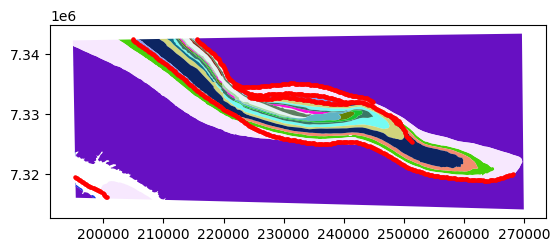

In [32]:
proj.draw_geology_map(overlay='faults')

In [26]:
proj.map_data.get_map_data(Datatype.FAULT)

,geometry,FEATURE,NAME,DIP,DIPDIR,ID
27,"MULTILINESTRING ((199907.62 7316868.374, 19998...",Thrust,Fault_27,45.0,45.0,27
22,"LINESTRING (251417.191 7325419.813, 251342.731...",Thrust,Gardiner Thrust Fault,45.0,225.0,22
30,"MULTILINESTRING ((269903.992 7322720.05, 26980...",Reverse,Fault_30,75.0,0.0,30
21,"LINESTRING (249379.016 7328462.724, 249354.74 ...",Thrust,Gardiner Thrust Fault,45.0,180.0,21
28,"LINESTRING (243012.251 7330794.189, 242705.201...",Reverse,Fault_28,75.0,180.0,28
23,"LINESTRING (249379.016 7328462.724, 249319.803...",Thrust,Gardiner Thrust Fault,45.0,180.0,23
19,"LINESTRING (204856.175 7342430.593, 204986.013...",Thrust,Fault_19,NaN,45.0,19
18,"LINESTRING (221433.965 7334847.234, 221404.264...",Thrust,Fault_18,45.0,225.0,18
26,"LINESTRING (221404.264 7334873.219, 221401.716...",Thrust,Gardiner Thrust Fault,45.0,180.0,26
31,"MULTILINESTRING ((233947.471 7329569.518, 2334...",Reverse,Fault_31,75.0,225.0,31


In [12]:
from LoopStructural import GeologicalModel
import pandas

In [118]:
site_data = pandas.DataFrame(pandas.read_csv('site_data_processed.csv'))
site_data["strike"] = (site_data["dipdir"] + 90) % 360
origin = [0, 0, 0]
maximum = [10000, 10000, 3000]
model = GeologicalModel(origin, maximum)
model.data = site_data 
data = model.data.copy()
data = pandas.concat([processedData.data, data])
data.loc[data['feature_name'] == 'sg', 'feature_name'] = 's0'

x = model.data["X"]
y = model.data["Y"]
z = model.data["Z"]
# xyz = numpy.column_stack((x, y, z))
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
bbox = (xmin, ymin, xmax, ymax)
origin = [xmin, ymin, 0]
maximum = [xmax, ymax, 3000]

model = GeologicalModel(origin, maximum)
model.data = data

In [108]:
site_data = pandas.DataFrame(pandas.read_csv('site_data_processed.csv'))
site_data["strike"] = (site_data["dipdir"] + 90) % 360
model.data = site_data 
data = model.data.copy()
data = pandas.concat([processedData.data, data])
data.loc[data['feature_name'] == 'sg', 'feature_name'] = 's0'


In [124]:
s0 = model.create_and_add_foliation(
    's0',
    nelements=5e5,
    interpolatortype='FDI',
    # gw=0.0001,
    buffer=1,
    )
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
view = Loop3DView(model)
view.nsteps=np.array([500,500,50])
for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])
view.nelements = 1e6
# view.nsteps = np.array([500,500,50])
# view.plot_block_model()
# view.nelements=1e6
view.plot_scalar_field(s0 , cmap='prism')
# view.plot_model_surfaces(model=model ,strati=False, )
view.plot_data(model.features)

# if(clip_on_dtm):

#     colours = list(pd.DataFrame(data=proj.stratigraphic_column.column,columns=["name"]).merge(proj.stratigraphic_column.stratigraphicUnits[["name","colour"]], on="name")["colour"])
#     colours.reverse()
    # view.add_dtm(paint_with=lambda xyz: model.evaluate_model(xyz,scale=False), cmap=colours)
# view.add_model()
view.display()

Widget(value='<iframe src="http://localhost:34621/index.html?ui=P_0x7f5af6662a90_21&reconnect=auto" class="pyv…

In [92]:
s0

-----------------------------------------------------
s0 1 
-----------------------------------------------------
	0 regions
	0 faults.
	Fault enabled True

In [13]:
from LoopStructural import GeologicalModel
import pandas


In [15]:
loop_converter.data[Datatype.STRUCTURE]["feature_name"] = loop_converter.data[Datatype.STRUCTURE].ObsType

In [14]:
from map2loop.interpolators import DipDipDirectionInterpolator

In [13]:
interpolator = DipDipDirectionInterpolator(data_type=["dip", "dipdir"])
interp_data = interpolator(bounding_box=bounding_box, structure_data=loop_converter.data[Datatype.STRUCTURE])

NameError: name 'DipDipDirectionInterpolator' is not defined

In [15]:
loop_converter.data[Datatype.STRUCTURE].rename(columns={'DipDir': 'DIPDIR',
                                                        'Dip':'DIP',
                                                        }, inplace=True)

In [16]:
interp_data = interpolator(bounding_box=bounding_box, structure_data=loop_converter.data[Datatype.STRUCTURE])

NameError: name 'interpolator' is not defined

In [11]:
datax = pandas.DataFrame()
datax["X"] = interpolator.xi
datax["Y"] = interpolator.yi
datax["Z"] = 0.
datax["dip"] = interp_data[:, 0]
datax["strike"] = (interp_data[:, 1] - 90) % 360
datax["feature_name"] = "s0"

In [ ]:
original_data

,MSID,Latitude,Longitude,Datum,ObsType,InterpSrce,LocMethod,LocAcc,dipdir,dip,...,Desc_,FeatDesc,FeatCode,geometry,Strike,X,Y,Z,strike,feature_name
3,HB113,-24.0763,132.205,GDA94,Bedding,Geological mapping,GPS,<5m,220,36,...,NaN,Strike and dip of strata,1400100,POINT (215807.999 7334497.995),310,215807.998820,7.334498e+06,0.0,130,s0
4,HB114,-24.0708,132.215,GDA94,Bedding,Geological mapping,GPS,<5m,220,20,...,NaN,Strike and dip of strata,1400100,POINT (216836 7335127.997),310,216835.999982,7.335128e+06,0.0,130,s0
5,HB115,-24.0597,132.229,GDA94,Bedding,Geological mapping,GPS,<5m,217,38,...,NaN,Strike and dip of strata,1400100,POINT (218247.004 7336383.002),307,218247.004121,7.336383e+06,0.0,127,s0
6,HB121,-24.2245,132.611,GDA94,Bedding,Geological mapping,GPS,<5m,179,33,...,NaN,Strike and dip of strata,1400100,POINT (257398.001 7318842.002),269,257398.000726,7.318842e+06,0.0,89,s0
7,HB122,-24.2143,132.612,GDA94,Bedding,Geological mapping,GPS,<5m,176,41,...,NaN,Strike and dip of strata,1400100,POINT (257450.997 7319972.002),266,257450.996768,7.319972e+06,0.0,86,s0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,HB883,-24.1203,132.348,GDA94,Bedding,Geological mapping,GPS,<5m,18,89,...,NaN,Strike and dip of inverted strata,1401100,POINT (230474 7329901.001),108,230473.999764,7.329901e+06,0.0,288,s0
86,HB885,-24.0774,132.265,GDA94,Bedding,Geological mapping,250K map,Unknown,209,78,...,Data from First Edition 250K Henbury geologica...,Strike and dip of inverted strata,1401100,POINT (221932.995 7334496.915),299,221932.995471,7.334497e+06,0.0,119,s0
87,HB908,-24.2174,132.121,GDA94,Bedding,Geological mapping,250K map,Unknown,29,10,...,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (207619.842 7318694.242),119,207619.842450,7.318694e+06,0.0,299,s0
88,HB909,-24.0873,132.100,GDA94,Bedding,Geological mapping,250K map,Unknown,217,10,...,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (205163.43 7333066.627),307,205163.430172,7.333067e+06,0.0,127,s0


In [17]:
origin = [bounding_box['minx'], bounding_box['miny'], bounding_box['base']]
maximum = [bounding_box['maxx'], bounding_box['maxy'], bounding_box['top']]
model = GeologicalModel(origin, maximum)

In [18]:
original_data = loop_converter.data[Datatype.STRUCTURE].copy()
original_data.rename(columns={'DIPDIR': 'dipdir',
                                                        'DIP':'dip',
                                                        }, inplace=True)
original_data["strike"] = (original_data['dipdir'] - 90) % 360 
original_data['feature_name'] = 's0'

In [19]:
model.data = original_data #datax.sample(frac=0.1, random_state=2)
model.data
s0 = model.create_and_add_foliation('s0', interpolatortype='FDI', nelements=1e5)
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
model.data


,MSID,Latitude,Longitude,Datum,ObsType,InterpSrce,LocMethod,LocAcc,dipdir,DipEst,...,gy,gz,w,val,coord,interface,polarity,l,u,pair_id
3,HB113,-24.0763,132.205,GDA94,Bedding,Geological mapping,GPS,<5m,220,NaN,...,-0.450270,0.809017,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
4,HB114,-24.0708,132.215,GDA94,Bedding,Geological mapping,GPS,<5m,220,NaN,...,-0.262003,0.939693,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
5,HB115,-24.0597,132.229,GDA94,Bedding,Geological mapping,GPS,<5m,217,NaN,...,-0.491689,0.788011,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
6,HB121,-24.2245,132.611,GDA94,Bedding,Geological mapping,GPS,<5m,179,NaN,...,-0.544556,0.838671,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
7,HB122,-24.2143,132.612,GDA94,Bedding,Geological mapping,GPS,<5m,176,NaN,...,-0.654461,0.754710,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,HB883,-24.1203,132.348,GDA94,Bedding,Geological mapping,GPS,<5m,18,NaN,...,0.950912,0.017452,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
86,HB885,-24.0774,132.265,GDA94,Bedding,Geological mapping,250K map,Unknown,209,NaN,...,-0.855507,0.207912,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
87,HB908,-24.2174,132.121,GDA94,Bedding,Geological mapping,250K map,Unknown,29,5-15,...,0.151876,0.984808,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN
88,HB909,-24.0873,132.100,GDA94,Bedding,Geological mapping,250K map,Unknown,217,5-15,...,-0.138682,0.984808,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN


In [15]:
from loopstructuralvisualisation import Loop3DView, Loop2DView

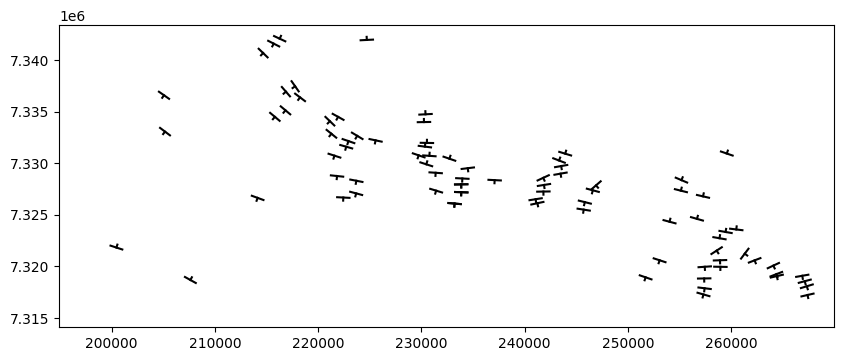

In [30]:
map_view = Loop2DView(model)

map_view.add_data(s0, val=False, grad=True, unfault=False, dip=False, symb_scale=600)

In [66]:
map_view.add_model( cmap='tab20')
map_view.show()

AttributeError: 'Loop2DView' object has no attribute 'show'

In [67]:
view = Loop3DView(model)
view.plot_scalar_field(s0, cmap='tab20')
view.display()

Widget(value='<iframe src="http://localhost:35437/index.html?ui=P_0x7fb2a2143610_9&reconnect=auto" class="pyvi…

In [22]:
original_data

,MSID,Latitude,Longitude,Datum,ObsType,InterpSrce,LocMethod,LocAcc,DIPDIR,DIP,DipEst,Desc_,FeatDesc,FeatCode,geometry,Strike,X,Y,Z,feature_name
3,HB113,-24.0763,132.205,GDA94,Bedding,Geological mapping,GPS,<5m,220,36,NaN,NaN,Strike and dip of strata,1400100,POINT (215807.999 7334497.995),310,215807.998820,7.334498e+06,0.0,Bedding
4,HB114,-24.0708,132.215,GDA94,Bedding,Geological mapping,GPS,<5m,220,20,NaN,NaN,Strike and dip of strata,1400100,POINT (216836 7335127.997),310,216835.999982,7.335128e+06,0.0,Bedding
5,HB115,-24.0597,132.229,GDA94,Bedding,Geological mapping,GPS,<5m,217,38,NaN,NaN,Strike and dip of strata,1400100,POINT (218247.004 7336383.002),307,218247.004121,7.336383e+06,0.0,Bedding
6,HB121,-24.2245,132.611,GDA94,Bedding,Geological mapping,GPS,<5m,179,33,NaN,NaN,Strike and dip of strata,1400100,POINT (257398.001 7318842.002),269,257398.000726,7.318842e+06,0.0,Bedding
7,HB122,-24.2143,132.612,GDA94,Bedding,Geological mapping,GPS,<5m,176,41,NaN,NaN,Strike and dip of strata,1400100,POINT (257450.997 7319972.002),266,257450.996768,7.319972e+06,0.0,Bedding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,HB883,-24.1203,132.348,GDA94,Bedding,Geological mapping,GPS,<5m,18,89,NaN,NaN,Strike and dip of inverted strata,1401100,POINT (230474 7329901.001),108,230473.999764,7.329901e+06,0.0,Bedding
86,HB885,-24.0774,132.265,GDA94,Bedding,Geological mapping,250K map,Unknown,209,78,NaN,Data from First Edition 250K Henbury geologica...,Strike and dip of inverted strata,1401100,POINT (221932.995 7334496.915),299,221932.995471,7.334497e+06,0.0,Bedding
87,HB908,-24.2174,132.121,GDA94,Bedding,Geological mapping,250K map,Unknown,29,10,5-15,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (207619.842 7318694.242),119,207619.842450,7.318694e+06,0.0,Bedding
88,HB909,-24.0873,132.100,GDA94,Bedding,Geological mapping,250K map,Unknown,217,10,5-15,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (205163.43 7333066.627),307,205163.430172,7.333067e+06,0.0,Bedding


In [23]:
original_data = loop_converter.data[Datatype.STRUCTURE].copy()
original_data.rename(columns={
                                                        'Dip':'dip',
                                                        }, inplace=True)
original_data["strike"] = (original_data['DIPDIR'] - 90) % 360 
original_data['feature_name'] = 's0'
geodata = original_data.copy()

In [57]:
import numpy
from scipy.optimize import minimize

import shapely
import math


def calculate_endpoints(
    start_point: shapely.Point, azimuth_deg: float, distance: int, bbox: pandas.DataFrame
) -> shapely.geometry.LineString:
    """
    Calculate the endpoints of a line segment given a start point, azimuth angle, distance, and bounding box.

    Parameters:
    start_point (tuple): The coordinates of the start point (x, y).
    azimuth_deg (float): The azimuth angle in degrees.
    distance (float): The distance of the line segment.
    bbox (dict): The bounding box coordinates (minx, miny, maxx, maxy).

    Returns:
    shapely.LineString: A LineString object representing the line segment with endpoints clipped by the bounding box.
    """
    # bbox = numpy.array(bbox)[0]
    minx, miny, maxx, maxy = bbox['minx'], bbox['miny'], bbox['maxx'], bbox['maxy']
    x, y = start_point.coords[0]
    azimuth_rad = math.radians(90 - azimuth_deg)

    # Calculate the perpendicular azimuths in radians
    right_azimuth_rad = (azimuth_rad + math.pi / 2) % (2 * math.pi)
    left_azimuth_rad = (azimuth_rad - math.pi / 2) % (2 * math.pi)

    # Calculate offsets for the right-hand perpendicular direction
    dx_right = distance * math.cos(right_azimuth_rad)
    dy_right = distance * math.sin(right_azimuth_rad)
    right_endpoint = (x + dx_right, y + dy_right)

    # Calculate offsets for the left-hand perpendicular direction
    dx_left = distance * math.cos(left_azimuth_rad)
    dy_left = distance * math.sin(left_azimuth_rad)
    left_endpoint = (x + dx_left, y + dy_left)

    line = shapely.LineString([left_endpoint, right_endpoint])

    new_line = shapely.ops.clip_by_rect(line, minx, miny, maxx, maxy)

    return new_line


def strike_dip_vector(strike, dip) -> numpy.ndarray:
    """
    Calculates the strike-dip vector from the given strike and dip angles.

    Args:
        strike (Union[float, list, numpy.ndarray]): The strike angle(s) in degrees.
        dip (Union[float, list, numpy.ndarray]): The dip angle(s) in degrees.

    Returns:
        numpy.ndarray: The calculated strike-dip vector(s). Each row corresponds to a vector,
        and the columns correspond to the x, y, and z components of the vector.
    """

    # If strike or dip is a single value, wrap them into a list
    if not isinstance(strike, (list, numpy.ndarray)):
        strike = [strike]
    if not isinstance(dip, (list, numpy.ndarray)):
        dip = [dip]

    # Convert to numpy arrays
    strike = numpy.array(strike)
    dip = numpy.array(dip)

    # Initialize a zero matrix with shape (n, 3)
    vec = numpy.zeros((len(strike), 3))

    # Convert strike and dip from degrees to radians
    s_r = numpy.deg2rad(strike)
    d_r = numpy.deg2rad(dip)

    # Compute the x, y, and z components of the strike-dip vector
    vec[:, 0] = numpy.sin(d_r) * numpy.cos(s_r)
    vec[:, 1] = -numpy.sin(d_r) * numpy.sin(s_r)
    vec[:, 2] = numpy.cos(d_r)

    # Normalize the vectors
    norms = numpy.linalg.norm(vec, axis=1)[:, None]
    vec = vec / norms

    return vec

def normal_vector_to_dipdirection_dip(normal_vector: numpy.ndarray) -> numpy.ndarray:
    """
    Calculates the dip and dip direction from a normal vector.

    Args:
        normal_vector (numpy.ndarray): The normal vector(s) for which to calculate the dip and dip direction.
            Each row corresponds to a vector, and the columns correspond to the x, y, and z components of the vector.

    Returns:
        numpy.ndarray: The calculated dip and dip direction(s). Each row corresponds to a set of dip and dip direction,
        and the columns correspond to the dip and dip direction, respectively.

    Note:
        This code is adapted from LoopStructural.
    """

    # Calculate the dip direction in degrees, ranging from 0 to 360
    dipdir = numpy.degrees(numpy.arctan2(normal_vector[:, 0], normal_vector[:, 1])) % 360

    # Calculate the dip angle in degrees, ranging from 0 to 90
    dip = 90 - numpy.degrees(numpy.arcsin(normal_vector[:, 2]))

    # If the dip angle is greater than 90 degrees, adjust the dip and dip direction
    mask = dip > 90
    dip[mask] = 180 - dip[mask]
    dipdir[mask] = (dipdir[mask] + 180) % 360

    # Ensure the dip direction is within the range of 0 to 360 degrees
    dipdir = dipdir % 360
    dip_dipdir = numpy.array([dip, dipdir]).T

    return dip_dipdir

def rotate_vectors(v, angle, dimension=2):
    """
    Rotate a vector by a given angle around the origin using a rotation matrix.
    Args:
        v (ndarray): The vector to rotate.
        angle (float): The angle to rotate the vector by in radians.
        dimension (int): The dimension of the vector (2 or 3). Default is 2.
    Returns:
        ndarray: The rotated vector.
    """
    if dimension == 2:
        # Define the 2D rotation matrix
        R = numpy.array(
            [
                [numpy.cos(angle), -numpy.sin(angle)],
                [numpy.sin(angle), numpy.cos(angle)],
            ]
        )
    elif dimension == 3:
        # Define the 3D rotation matrix
        R = numpy.array(
            [
                [numpy.cos(angle), -numpy.sin(angle), 0],
                [numpy.sin(angle), numpy.cos(angle), 0],
                [0, 0, 1],
            ]
        )
    else:
        raise ValueError("Dimension must be either 2 or 3.")

    # Rotate the vector by multiplying with the rotation matrix
    # R = numpy.tile(R, (len(v), 1))
    v_rotated = numpy.dot(v, R.T)
    v_rotated /= numpy.linalg.norm(v_rotated, axis=1)[:, None]

    return v_rotated

# Objective function to minimize
def objective(params, normals):
    a, b, c = params[:3]
    normal_plane = numpy.array([a, b, c])
    normal_plane /= numpy.linalg.norm(normal_plane)  # Normalize the plane normal vector
    
    errors = []
    for normal_obs in normals:
        # Compute cosine of angle between normal_obs and normal_plane
        cos_angle = numpy.abs(numpy.dot(normal_obs, normal_plane) / 
                           (numpy.linalg.norm(normal_obs) * numpy.linalg.norm(normal_plane)))
        errors.append(1 - cos_angle)  # Minimize angular deviation
    
    return numpy.sum(errors)


In [26]:
geodata

,MSID,Latitude,Longitude,Datum,ObsType,InterpSrce,LocMethod,LocAcc,DIPDIR,DIP,...,Desc_,FeatDesc,FeatCode,geometry,Strike,X,Y,Z,strike,feature_name
3,HB113,-24.0763,132.205,GDA94,Bedding,Geological mapping,GPS,<5m,220,36,...,NaN,Strike and dip of strata,1400100,POINT (215807.999 7334497.995),310,215807.998820,7.334498e+06,0.0,130,s0
4,HB114,-24.0708,132.215,GDA94,Bedding,Geological mapping,GPS,<5m,220,20,...,NaN,Strike and dip of strata,1400100,POINT (216836 7335127.997),310,216835.999982,7.335128e+06,0.0,130,s0
5,HB115,-24.0597,132.229,GDA94,Bedding,Geological mapping,GPS,<5m,217,38,...,NaN,Strike and dip of strata,1400100,POINT (218247.004 7336383.002),307,218247.004121,7.336383e+06,0.0,127,s0
6,HB121,-24.2245,132.611,GDA94,Bedding,Geological mapping,GPS,<5m,179,33,...,NaN,Strike and dip of strata,1400100,POINT (257398.001 7318842.002),269,257398.000726,7.318842e+06,0.0,89,s0
7,HB122,-24.2143,132.612,GDA94,Bedding,Geological mapping,GPS,<5m,176,41,...,NaN,Strike and dip of strata,1400100,POINT (257450.997 7319972.002),266,257450.996768,7.319972e+06,0.0,86,s0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,HB883,-24.1203,132.348,GDA94,Bedding,Geological mapping,GPS,<5m,18,89,...,NaN,Strike and dip of inverted strata,1401100,POINT (230474 7329901.001),108,230473.999764,7.329901e+06,0.0,288,s0
86,HB885,-24.0774,132.265,GDA94,Bedding,Geological mapping,250K map,Unknown,209,78,...,Data from First Edition 250K Henbury geologica...,Strike and dip of inverted strata,1401100,POINT (221932.995 7334496.915),299,221932.995471,7.334497e+06,0.0,119,s0
87,HB908,-24.2174,132.121,GDA94,Bedding,Geological mapping,250K map,Unknown,29,10,...,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (207619.842 7318694.242),119,207619.842450,7.318694e+06,0.0,299,s0
88,HB909,-24.0873,132.100,GDA94,Bedding,Geological mapping,250K map,Unknown,217,10,...,Data from First Edition 250K Henbury geologica...,"Strike and dip of strata, dip 5 to 15 degrees",1403100,POINT (205163.43 7333066.627),307,205163.430172,7.333067e+06,0.0,127,s0


In [45]:
import numpy
x = geodata["X"].to_numpy()
y = geodata["Y"].to_numpy()
z = geodata["Z"].to_numpy()
points = original_data.geometry
strike = original_data["strike"].to_numpy()
dip = original_data["DIP"].to_numpy()
coords = []
normal_vec = []
s0g = []
lines = []
for i, point in enumerate(points):
    line = calculate_endpoints(point, strike[i], 10000, bounding_box)
    lines.append(line)
    line_length = shapely.length(line)
    indices = shapely.dwithin(line, geodata.geometry, line_length * 0.01)
    s = strike[indices]
    d = dip[indices]
    si = strike[i]
    di = dip[i]
    sr = numpy.column_stack(([[s, d], [si, di]]))
    print(f"Strike: {s}, Dip: {d}")
    # Convert to normal vectors
    normals = strike_dip_vector(s, d)
    ni = strike_dip_vector(si, di)
    s0g.append(ni)

    # Initial guess for the plane parameters (a, b, c)
    initial_guess = numpy.array([1, 1, 1])

    # Perform optimization
    result = minimize(objective, initial_guess, args=(normals,), method='BFGS')

    # Extract the optimized plane parameters
    a, b, c = result.x
    normal_plane = numpy.array([a, b, c])
    normal_plane /= numpy.linalg.norm(normal_plane)  # Normalize
    coords.append([x[i], y[i], z[i]])
    normal_vec.append(normal_plane)
    print(f"Optimized plane normal vector: {normal_plane}")
    # print(f"Plane equation: {normal_plane[0]:.3f}x + {normal_plane[1]:.3f}y + {normal_plane[2]:.3f}z = 0")

Strike: [130], Dip: [36]
Optimized plane normal vector: [ 0.37786428  0.45031278 -0.8089728 ]
Strike: [130], Dip: [20]
Optimized plane normal vector: [-0.21982939 -0.26198542  0.93970138]
Strike: [127], Dip: [38]
Optimized plane normal vector: [ 0.37052401  0.49169871 -0.78800021]
Strike: [ 89  86 283 106  97], Dip: [33 41 14 15 20]
Optimized plane normal vector: [-7.04260924e-04 -3.27958970e-01  9.44691705e-01]
Strike: [89 86 97], Dip: [33 41 20]
Optimized plane normal vector: [ 0.00458431 -0.51910895  0.85469578]
Strike: [277], Dip: [30]
Optimized plane normal vector: [0.06093733 0.49627393 0.86602473]
Strike: [93 89 92 89 92], Dip: [48 52 67 52 67]
Optimized plane normal vector: [ 0.01528569  0.84024757 -0.54198743]
Strike: [93 89 92 89 92], Dip: [48 52 67 52 67]
Optimized plane normal vector: [ 0.01528569  0.84024757 -0.54198743]
Strike: [93 89 92 89 92], Dip: [48 52 67 52 67]
Optimized plane normal vector: [ 0.01528569  0.84024757 -0.54198743]
Strike: [95 95], Dip: [50 50]
Optimiz

<Axes: >

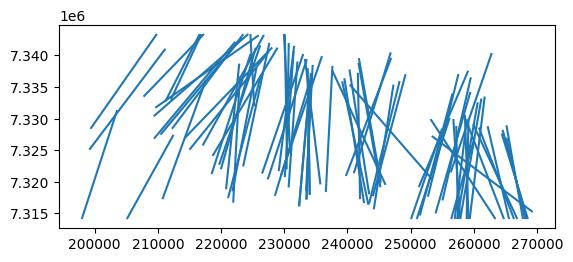

In [28]:
geoline = geopandas.GeoDataFrame(geometry=lines)
geoline.plot()

array([[-0.37782108, -0.45026963,  0.80901699],
       [-0.21984631, -0.26200263,  0.93969262],
       [-0.37051433, -0.49168912,  0.78801075],
       [ 0.00950526, -0.54455608,  0.83867057],
       [ 0.04576436, -0.6544609 ,  0.75470958],
       [ 0.05442059,  0.23572145,  0.97029573],
       [-0.0713402 , -0.24879283,  0.96592583],
       [-0.04168177, -0.33947078,  0.93969262],
       [ 0.00950526, -0.54455608,  0.83867057],
       [ 0.04576436, -0.6544609 ,  0.75470958],
       [-0.04168177, -0.33947078,  0.93969262],
       [ 0.06093467,  0.49627308,  0.8660254 ],
       [-0.0388932 , -0.74212637,  0.66913061],
       [ 0.01375268, -0.78789074,  0.61566148],
       [-0.03212516, -0.91994411,  0.39073113],
       [ 0.01375268, -0.78789074,  0.61566148],
       [-0.03212516, -0.91994411,  0.39073113],
       [-0.0388932 , -0.74212637,  0.66913061],
       [ 0.01375268, -0.78789074,  0.61566148],
       [-0.03212516, -0.91994411,  0.39073113],
       [ 0.01375268, -0.78789074,  0.615

In [64]:
axis_p = numpy.array(normal_vec)
s0g = numpy.vstack(s0g)
s1g = numpy.cross(axis_p, s0g)
s1g = s1g / numpy.linalg.norm(s1g, axis=1)[:, None]
s1g = rotate_vectors(normal_vec, -numpy.pi, dimension=3)

In [41]:
len(s0g), len(axis_p)

(185, 85)

In [70]:
ddir = normal_vector_to_dipdirection_dip(numpy.array(axis_p))
s1_data = pandas.DataFrame()
s1_data["X"] = numpy.array(coords)[:, 0]
s1_data["Y"] = numpy.array(coords)[:, 1]
s1_data["Z"] = numpy.array(coords)[:, 2]
s1_data["DIP"] = ddir[:, 0]
s1_data["DIPDIR"] = ddir[:, 1]
s1_data["dip"] = ddir[:, 0]
s1_data["strike"] = (ddir[:, 1] - 90) % 360
s1_data["feature_name"] = "s1"

interpolator = DipDipDirectionInterpolator(data_type=["dip", "dipdir"])
interp_data = interpolator(bounding_box=bounding_box, structure_data=s1_data)

# s1_data = pandas.DataFrame()
# s1_data["X"] = interpolator.xi
# s1_data["Y"] = interpolator.yi
# s1_data["Z"] = 0.
# s1_data["dip"] = interp_data[:, 0]
# s1_data["strike"] = (interp_data[:, 1] - 90) % 360
# s1_data["feature_name"] = "s1"

In [71]:
model.data = s1_data
model.data
s1 = model.create_and_add_foliation('s1', interpolatortype='FDI', nelements=1e5)
model.update()

  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
from loopstructuralvisualisation import Loop3DView, Loop2DView

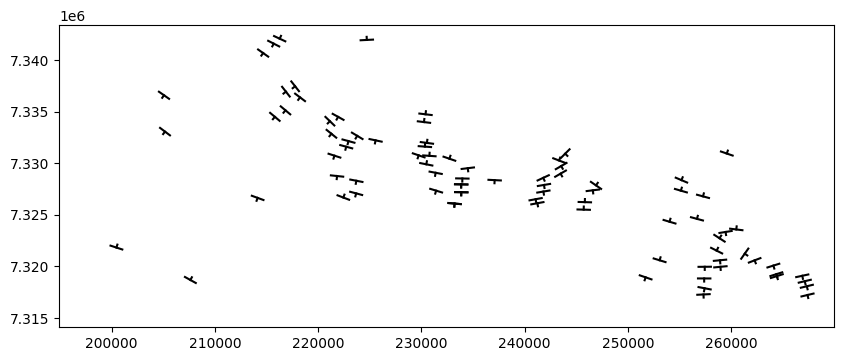

In [73]:
map_view = Loop2DView(model)
map_view.add_data(s1, val=False, grad=True, unfault=False, dip=False, symb_scale=600)

In [74]:
view = Loop3DView(model)
view.plot_scalar_field(s1, cmap='tab20')
view.display()

Widget(value='<iframe src="http://localhost:45979/index.html?ui=P_0x7f62a39b38d0_6&reconnect=auto" class="pyvi…

In [31]:
from FoldOptLib.utils import rotate_vector, create_gradient_dict, create_fold_frame_dataset

def rotate_vectors(v, angle, dimension=2):
    """
    Rotate a vector by a given angle around the origin using a rotation matrix.
    Args:
        v (ndarray): The vector to rotate.
        angle (float): The angle to rotate the vector by in radians.
        dimension (int): The dimension of the vector (2 or 3). Default is 2.
    Returns:
        ndarray: The rotated vector.
    """
    if dimension == 2:
        # Define the 2D rotation matrix
        R = numpy.array(
            [
                [numpy.cos(angle), -numpy.sin(angle)],
                [numpy.sin(angle), numpy.cos(angle)],
            ]
        )
    elif dimension == 3:
        # Define the 3D rotation matrix
        R = numpy.array(
            [
                [numpy.cos(angle), -numpy.sin(angle), 0],
                [numpy.sin(angle), numpy.cos(angle), 0],
                [0, 0, 1],
            ]
        )
    else:
        raise ValueError("Dimension must be either 2 or 3.")

    # Rotate the vector by multiplying with the rotation matrix
    # R = numpy.tile(R, (len(v), 1))
    v_rotated = numpy.dot(v, R.T)
    v_rotated /= numpy.linalg.norm(v_rotated, axis=1)[:, None]

    return v_rotated

def create_dataset(
    vec: numpy.ndarray, points: numpy.ndarray, name: str = "s0", coord: int = 0
) -> pandas.DataFrame:
    """

    Make a dataset from one unit vector and xyz points of the folded feature data.

    Parameters
    ----------
    vec : numpy.ndarray
        The unit vector to be used as the gradient.
    points : numpy.ndarray
        The xyz coordinates of the data points.
    name : str, optional
        The name of the feature, by default 's0'.
    coord : int, optional
        The coordinate, by default 0.

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row represents a data point with its coordinates (X, Y, Z),
        gradient (gx, gy, gz), feature name, and coordinate.
    """
    # g = numpy.tile(vec, (len(points), 1))
    g = vec
    dataset = pandas.DataFrame()
    dataset["X"] = points[:, 0]
    dataset["Y"] = points[:, 1]
    dataset["Z"] = points[:, 2]
    dataset["gx"] = g[:, 0]
    dataset["gy"] = g[:, 1]
    dataset["gz"] = g[:, 2]
    dataset["feature_name"] = name
    dataset["coord"] = coord
    dataset["weight"] = 1.0

    return dataset


In [52]:
s1g = model.data[['gx', 'gy', 'gz']].to_numpy()
xyz = s1_data[['X', 'Y', 'Z']].to_numpy()
s1gy = rotate_vectors(s1g, numpy.pi/2, dimension=3)

In [53]:
s1gy_df = create_dataset(s1gy, xyz, 's1', coord=1)   
s1g_df = model.data.copy()
s1_df = pandas.concat([s1g_df, s1gy_df])

ValueError: Length of values (170) does not match length of index (85)

In [36]:
model.data = s1_df

In [41]:
s1g = model.create_and_add_fold_frame('s1', interpolatortype='FDI', nelements=1e5, buffer=0.2)
model.update()

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2025-01-29 13:58:20,607: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more


In [42]:
view = Loop3DView(model)
view.plot_scalar_field(s1g[1], cmap='tab20')
view.display()

Widget(value='<iframe src="http://localhost:43495/index.html?ui=P_0x7f2ace2f6dd0_2&reconnect=auto" class="pyvi…

In [47]:
s1g[1].evaluate_gradient(xyz)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [50]:
s1_df

,X,Y,Z,DIP,DIPDIR,feature_name,nx,ny,nz,tx,...,gz,w,val,coord,interface,polarity,l,u,pair_id,weight
0,20892.951164,20386.460857,3000.0,36.004308,220.000522,s1,NaN,NaN,NaN,NaN,...,0.808973,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN
1,21920.952327,21016.462622,3000.0,19.998533,219.999682,s1,NaN,NaN,NaN,NaN,...,0.939701,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN
2,23331.956465,22271.467169,3000.0,38.000981,217.000182,s1,NaN,NaN,NaN,NaN,...,0.788000,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN
3,62482.953071,4730.467588,3000.0,19.144986,180.123037,s1,NaN,NaN,NaN,NaN,...,0.944692,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN
4,62535.949112,5860.467579,3000.0,31.273857,179.494027,s1,NaN,NaN,NaN,NaN,...,0.854696,1.0,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,35558.952109,15789.466561,3000.0,NaN,NaN,s1,NaN,NaN,NaN,NaN,...,0.226555,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0
81,27017.947816,20385.381077,3000.0,NaN,NaN,s1,NaN,NaN,NaN,NaN,...,0.207911,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0
82,12704.794794,4582.707666,3000.0,NaN,NaN,s1,NaN,NaN,NaN,NaN,...,0.984808,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0
83,10248.382516,18955.092209,3000.0,NaN,NaN,s1,NaN,NaN,NaN,NaN,...,0.984810,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0


In [51]:
s1_data

,X,Y,Z,DIP,DIPDIR,dip,strike,feature_name
0,215807.998820,7.334498e+06,0.0,36.004308,220.000522,36.004308,130.000522,s1
1,216835.999982,7.335128e+06,0.0,19.998533,219.999682,19.998533,129.999682,s1
2,218247.004121,7.336383e+06,0.0,38.000981,217.000182,38.000981,127.000182,s1
3,257398.000726,7.318842e+06,0.0,19.144986,180.123037,19.144986,90.123037,s1
4,257450.996768,7.319972e+06,0.0,31.273857,179.494027,31.273857,89.494027,s1
...,...,...,...,...,...,...,...,...
80,230473.999764,7.329901e+06,0.0,76.905691,11.345523,76.905691,281.345523,s1
81,221932.995471,7.334497e+06,0.0,78.000068,209.000021,78.000068,119.000021,s1
82,207619.842450,7.318694e+06,0.0,10.000002,29.000004,10.000002,299.000004,s1
83,205163.430172,7.333067e+06,0.0,9.999113,216.999353,9.999113,126.999353,s1
